# Modeling - XGBoost Classifier

**Obiettivo:** Classificazione IncidentGrade (TruePositive, BenignPositive, FalsePositive)

**Metrica:** Macro F1-Score

**Pipeline:**
1. Caricamento dati
2. Training XGBoost
3. Valutazione e cross-validation
4. Feature importance
5. Salvataggio modello

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score,
    accuracy_score
)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pickle
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')

print("Librerie importate con successo!")

Librerie importate con successo!


## 2. Caricamento Dati

In [2]:
print("Caricamento dataset processati...")

X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')['IncidentGrade']
y_test = pd.read_csv('../data/processed/y_test.csv')['IncidentGrade']

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"\nDistribuzione y_train:\n{y_train.value_counts(normalize=True)}")

Caricamento dataset processati...
X_train: (314230, 20)
X_test: (134671, 20)

Distribuzione y_train:
IncidentGrade
BenignPositive    0.485921
FalsePositive     0.301088
TruePositive      0.212990
Name: proportion, dtype: float64


In [3]:
# Encoding target
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print("Mapping label:")
for i, label in enumerate(le_target.classes_):
    print(f"  {label} -> {i}")

Mapping label:
  BenignPositive -> 0
  FalsePositive -> 1
  TruePositive -> 2


## 3. Training XGBoost

In [4]:
print("Training XGBoost...\n")

model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le_target.classes_),
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist',
    n_jobs=-1
)

model.fit(
    X_train, y_train_encoded,
    eval_set=[(X_test, y_test_encoded)],
    verbose=True
)

print("Training completato!")

Training XGBoost...

[0]	validation_0-mlogloss:1.04584
[1]	validation_0-mlogloss:1.02678
[2]	validation_0-mlogloss:1.01051
[3]	validation_0-mlogloss:0.99646
[4]	validation_0-mlogloss:0.98572
[5]	validation_0-mlogloss:0.97722
[6]	validation_0-mlogloss:0.96891
[7]	validation_0-mlogloss:0.96057
[8]	validation_0-mlogloss:0.95476
[9]	validation_0-mlogloss:0.94822
[10]	validation_0-mlogloss:0.94261
[11]	validation_0-mlogloss:0.93774
[12]	validation_0-mlogloss:0.93475
[13]	validation_0-mlogloss:0.93092
[14]	validation_0-mlogloss:0.92740
[15]	validation_0-mlogloss:0.92492
[16]	validation_0-mlogloss:0.92197
[17]	validation_0-mlogloss:0.91946
[18]	validation_0-mlogloss:0.91794
[19]	validation_0-mlogloss:0.91628
[20]	validation_0-mlogloss:0.91447
[21]	validation_0-mlogloss:0.91275
[22]	validation_0-mlogloss:0.91161
[23]	validation_0-mlogloss:0.91078
[24]	validation_0-mlogloss:0.90971
[25]	validation_0-mlogloss:0.90855
[26]	validation_0-mlogloss:0.90757
[27]	validation_0-mlogloss:0.90675
[28]	vali

## 4. Valutazione

In [5]:
y_pred = model.predict(X_test)

print("=" * 70)
print("PERFORMANCE TEST SET")
print("=" * 70)

print("\nClassification Report:")
print(classification_report(
    y_test_encoded, y_pred,
    target_names=le_target.classes_,
    digits=4
))

accuracy = accuracy_score(y_test_encoded, y_pred)
macro_f1 = f1_score(y_test_encoded, y_pred, average='macro')

print(f"\nACCURACY:          {accuracy:.4f}")
print(f"MACRO F1-SCORE:    {macro_f1:.4f} ⭐")

PERFORMANCE TEST SET

Classification Report:
                precision    recall  f1-score   support

BenignPositive     0.6149    0.7789    0.6873     65440
 FalsePositive     0.5473    0.5502    0.5487     40547
  TruePositive     0.5521    0.2121    0.3065     28684

      accuracy                         0.5893    134671
     macro avg     0.5714    0.5137    0.5142    134671
  weighted avg     0.5812    0.5893    0.5645    134671


ACCURACY:          0.5893
MACRO F1-SCORE:    0.5142 ⭐


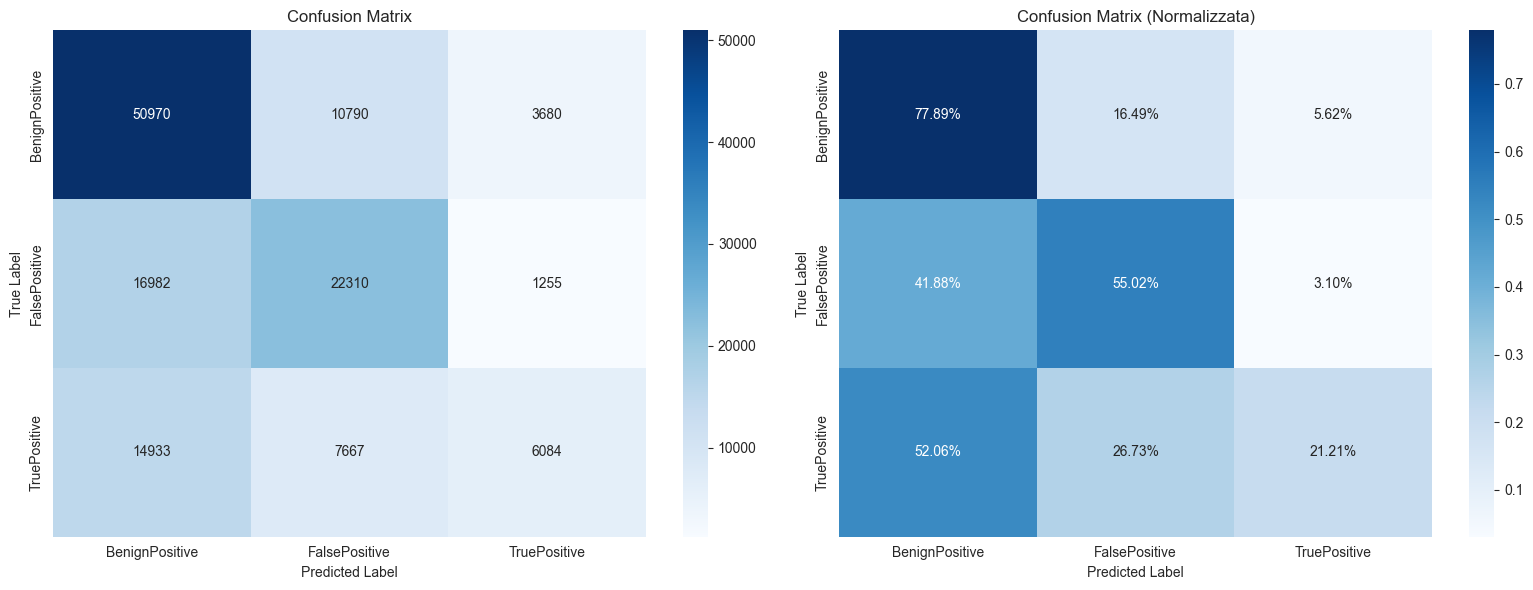

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalizzata)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Ottieni probabilità di predizione
y_pred_proba = model.predict_proba(X_test)

# Binarizza le label per ROC multi-class (One-vs-Rest)
y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Calcola ROC curve e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print("ROC AUC Scores:")
for i, class_name in enumerate(le_target.classes_):
    print(f"  {class_name}: {roc_auc[i]:.4f}")
print(f"  Micro-average: {roc_auc['micro']:.4f}")


ROC AUC Scores:
  BenignPositive: 0.7300
  FalsePositive: 0.7673
  TruePositive: 0.7011
  Micro-average: 0.7689


## 4.1 ROC Curve (One-vs-Rest)


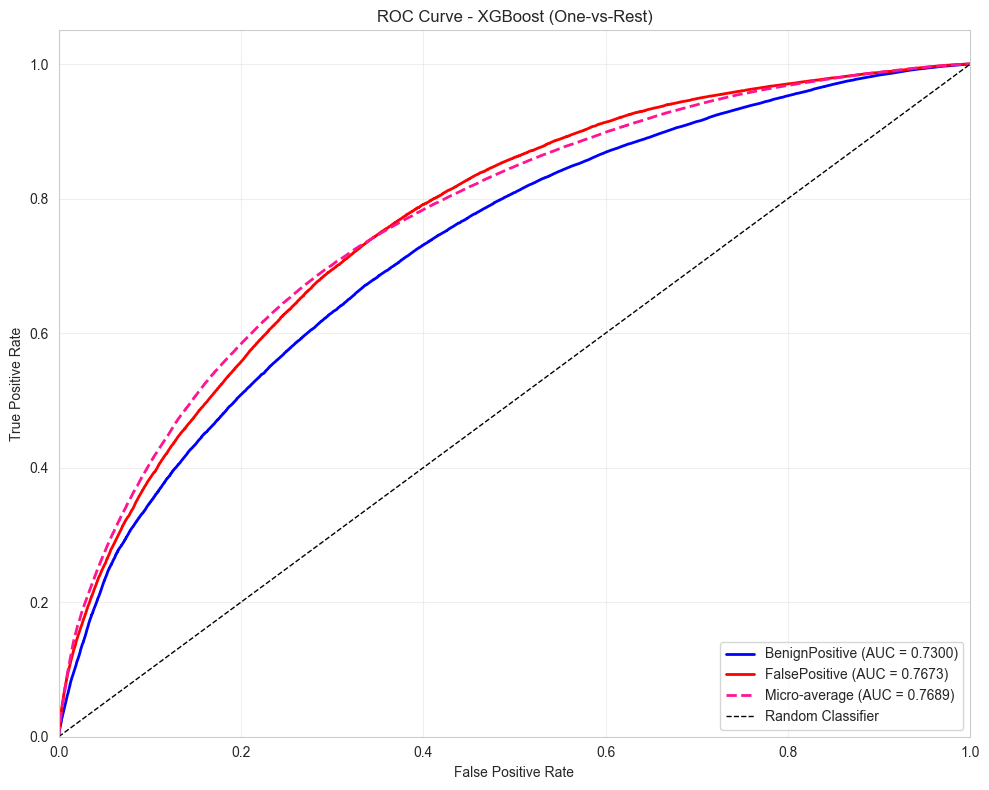

In [17]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{le_target.classes_[i]} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 5. Cross-Validation

In [18]:
print("Esecuzione 5-Fold Cross-Validation...\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    model, X_train, y_train_encoded,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"Cross-Validation Macro F1 Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMedia:  {cv_scores.mean():.4f}")
print(f"Std:    {cv_scores.std():.4f}")

Esecuzione 5-Fold Cross-Validation...

Cross-Validation Macro F1 Scores:
  Fold 1: 0.5082
  Fold 2: 0.5129
  Fold 3: 0.5151
  Fold 4: 0.5115
  Fold 5: 0.5124

Media:  0.5120
Std:    0.0022


## 6. Feature Importance

In [19]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 20 Features più importanti:")
print(feature_importance.head(20).to_string(index=False))

Top 20 Features più importanti:
           Feature  Importance
    NumWithVerdict    0.255539
 Category_get_mode    0.223981
      NumEvidences    0.119911
  NumWithSuspicion    0.059027
         NumAlerts    0.056636
         Hour_Last    0.045082
DayOfWeek_get_mode    0.035146
    NumEntityTypes    0.034187
     IsWeekend_max    0.030994
        Hour_First    0.022791
  Duration_seconds    0.019716
          Hour_Avg    0.018053
  NumEvidenceRoles    0.015594
 MITRE_unknown_sum    0.012236
   MITRE_T1566_sum    0.009782
   MITRE_T1078_sum    0.009738
   MITRE_T1110_sum    0.008937
   MITRE_T1059_sum    0.007843
  MITRE_n_rare_sum    0.007549
   MITRE_T1003_sum    0.007259


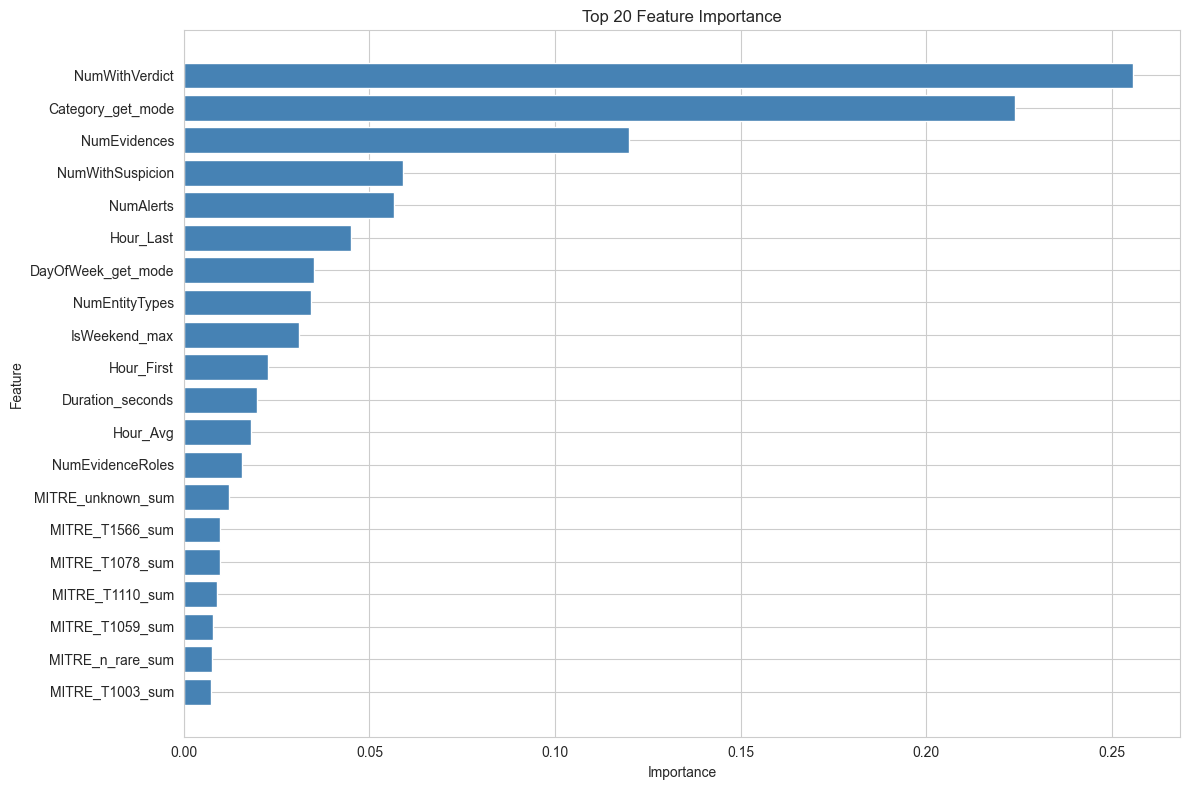

In [20]:
# Plot top features
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='steelblue')
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Salvataggio Modello

In [21]:
# Crea cartella per XGBoost
model_dir = '../models/xgboost'
os.makedirs(model_dir, exist_ok=True)

# Salva modello
model.save_model(f'{model_dir}/model.json')

with open(f'{model_dir}/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Salva label encoder
with open(f'{model_dir}/label_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)

# Salva feature importance
feature_importance.to_csv(f'{model_dir}/feature_importance.csv', index=False)

# Salva metriche (inclusa ROC AUC)
metrics = {
    'model_name': 'XGBoost',
    'timestamp': datetime.now().isoformat(),
    'test_accuracy': float(accuracy),
    'test_macro_f1': float(macro_f1),
    'cv_macro_f1_mean': float(cv_scores.mean()),
    'cv_macro_f1_std': float(cv_scores.std()),
    'roc_auc_per_class': {le_target.classes_[i]: float(roc_auc[i]) for i in range(n_classes)},
    'roc_auc_micro': float(roc_auc['micro']),
    'n_features': int(X_train.shape[1]),
    'n_train_samples': int(len(X_train)),
    'n_test_samples': int(len(X_test)),
    'hyperparameters': {
        'max_depth': model.max_depth,
        'learning_rate': float(model.learning_rate),
        'n_estimators': model.n_estimators,
        'subsample': float(model.subsample),
        'colsample_bytree': float(model.colsample_bytree)
    }
}

with open(f'{model_dir}/metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"Modello salvato in {model_dir}/")
print("  - model.json")
print("  - model.pkl")
print("  - label_encoder.pkl")
print("  - feature_importance.csv")
print("  - metrics.json")


Modello salvato in ../models/xgboost/
  - model.json
  - model.pkl
  - label_encoder.pkl
  - feature_importance.csv
  - metrics.json
